<a href="https://colab.research.google.com/github/Sukanya41455/Tensorflow_practice/blob/main/Multiple_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Manipulate complex graph topologies**

Models with multiple inputs and outputs 
https://keras.io/guides/functional_api/

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

In [33]:
num_tags = 12
num_words = 10000
num_departments = 4

title_input = keras.Input(shape=(None,),name='title')
body_input = keras.Input(shape=(None,), name='body')
tags_input = keras.Input(shape=(num_tags,), name='tags')

title_features = layers.Embedding(num_words, 64)(title_input)
body_features = layers.Embedding(num_words, 64)(body_input)

title_features = layers.LSTM(128)(title_features)
body_features = layers.LSTM(32)(body_features)

x = layers.concatenate([title_features, body_features, tags_input])

priority_pred = layers.Dense(1, name='priority')(x)
department_pred = layers.Dense(num_departments, name='department')(x)

model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

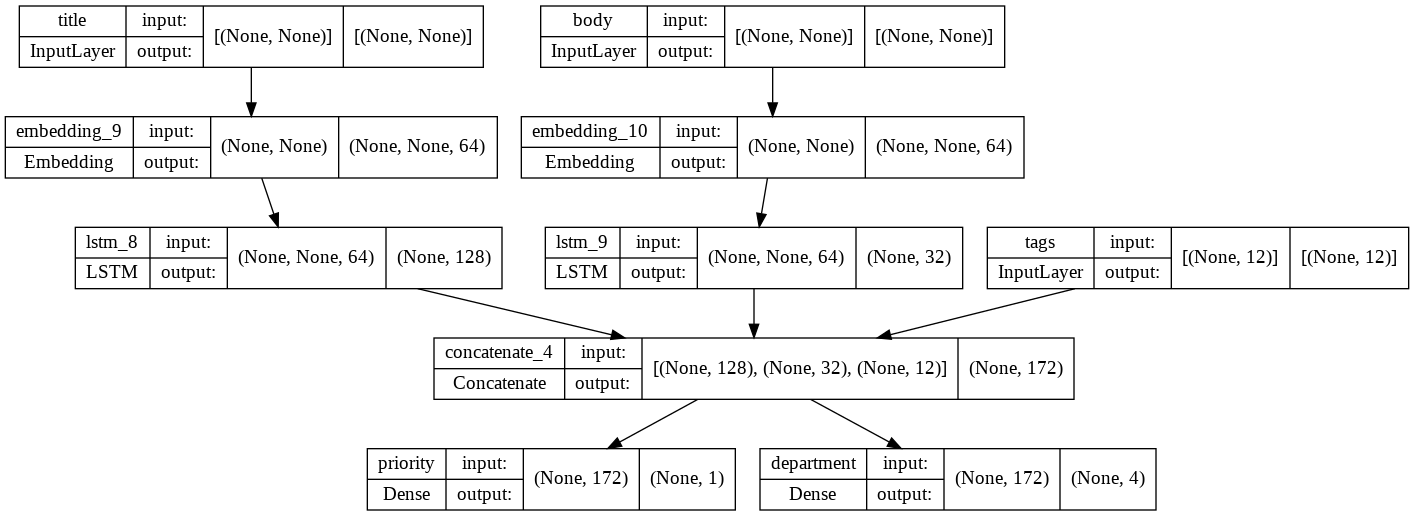

In [34]:
keras.utils.plot_model(model, show_shapes=True)

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority":1.0, "department":0.2},
)

In [36]:
# dummy input data
import numpy as np

title_data = np.random.randint(num_words, size=(1280,10))
body_data = np.random.randint(num_words, size=(1280,100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype('float32')

# dummy target data
priority_targets = np.random.random(size=(1280,1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {'title': title_data, 'body':body_data, 'tags':tags_data},
    {'priority': priority_targets, 'department': dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 6s 55ms/step - loss: 1.2757 - priority_loss: 0.7025 - department_loss: 2.8657
Epoch 2/2
40/40 [==============================] - 3s 83ms/step - loss: 1.2640 - priority_loss: 0.6974 - department_loss: 2.8329


ResNet Model

In [37]:
inputs = keras.Input(shape=(32,32,3), name='img')
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation='relu')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name='resnet')
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 28, 28, 64)   18496       ['conv2d_18[0][0]']              
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 9, 9, 64)    0           ['conv2d_19[0][0]']              
                                                                                             

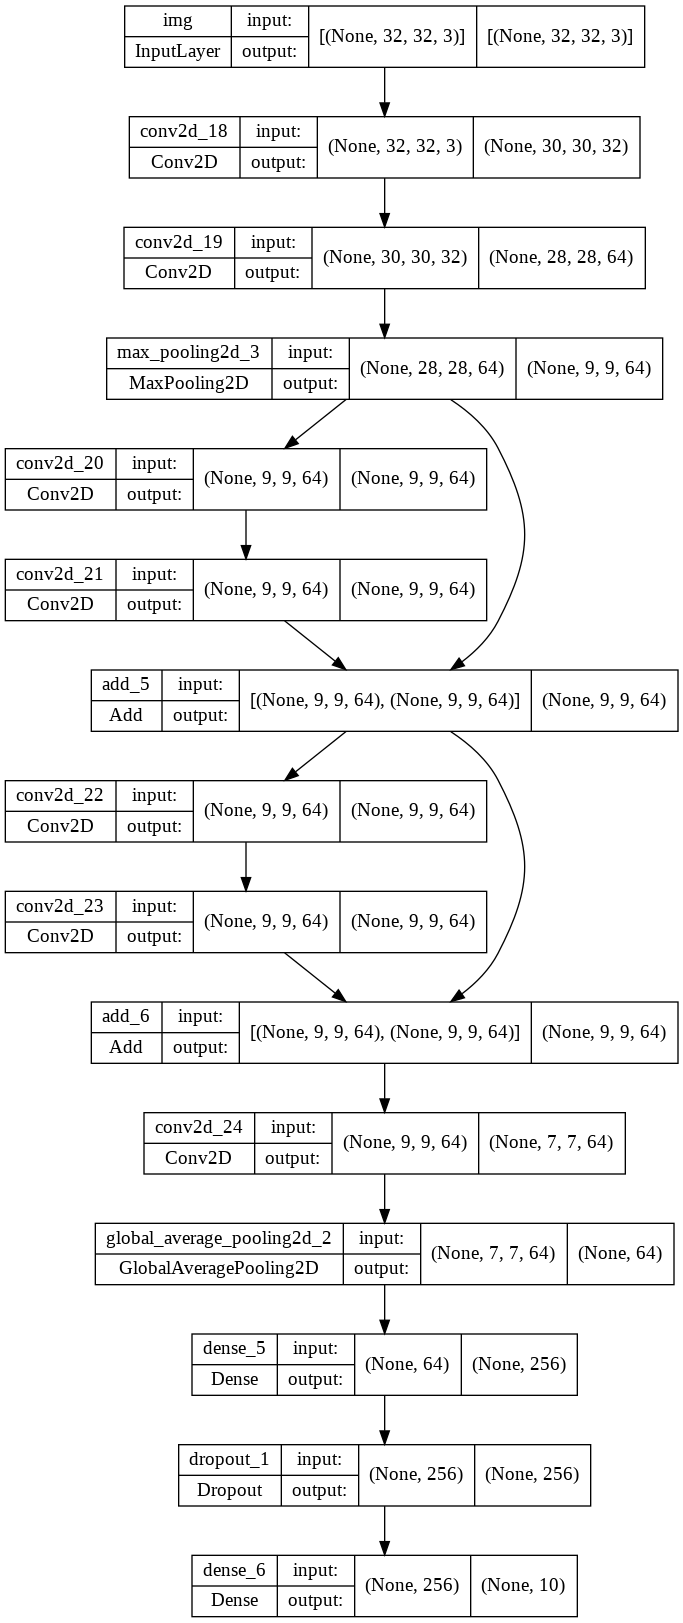

In [38]:
keras.utils.plot_model(model, show_shapes=True)

In [39]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

13/13 [==============================] - 5s 308ms/step - loss: 2.3118 - acc: 0.1063 - val_loss: 2.2863 - val_acc: 0.1250


**Shared layers**

In [40]:
shared_embedding = layers.Embedding(1000, 128)

text_input_a = keras.Input(shape=(None,), dtype='int32')
text_input_b = keras.Input(shape=(None,), dtype='int32')

encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

**Extract and reuse nodes in the graph of layers**

In [41]:
vgg19 = tf.keras.applications.VGG19()

In [42]:
features_list = [layer.output for layer in vgg19.layers]

In [43]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype('float32')
extracted_features = feat_extraction_model(img)

**Extend the API using custom layers**

In [44]:
class CustomDense(layers.Layer):
  def __init__(self, units=32):
    super(CustomDense, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(input_shape[-1], self.units),
        initializer='random_normal',
        trainable=True,
    )
    self.b = self.add_weight(
        shape=(self.units,), initializer='random_normal', trainable=True
    )

    def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

In [45]:
class CustomDense(layers.Layer):
  def __init__(self, units=32):
    super(CustomDense, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(input_shape[-1], self.units),
        initializer='random_normal',
        trainable=True,
    )
    self.b = self.add_weight(
        shape=(self.units,), initializer='random_normal', trainable=True
    )
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

  def get_config(self):
    return {'units': self.units}

inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = Model(inputs, outputs)
config = model.get_config()

new_model = Model.from_config(config, custom_objects={"CustomDense":CustomDense})

Mix-and-match API styles

In [46]:
units = 32
timesteps = 10
input_dim = 5

# functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

class CustomRNN(layers.Layer):
  def __init__(self):
    super(CustomRNN, self).__init__()
    self.units = units
    self.projection_1 = layers.Dense(units=units, activation='tanh')
    self.projection_2 = layers.Dense(units=units, activation='tanh')
    self.classifier = model # prev functional model

  def call(self, inputs):
    outputs = []
    state = tf.zeros(shape=(inputs.shape[0], self.units))
    for t in range(inputs.shape[-1]):
      x = inputs[:, t, :]
      h = self.projection_1(x)
      y = h + self.projection_2(state)
      state = y
      outputs.append(y)
    features = tf.stack(outputs, axis=1)
    print(features.shape)
    return self.classifier(features)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 5, 32)
